https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction

# Porto Seguro Exploratory Analysis and Prediction By Preda

**4번째 커널 첫번째**

# Analysis Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler 
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import VarianceThreshold, SelectFromModel 

from sklearn.model_selection import StratifiedKFold, cross_val_score 

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 
from sklearn.linear_model import LogisticRegression 

pd.set_option('display.max_columns',100)

# Load the data 

In [2]:
trainset = pd.read_csv('../data/train.csv')
testset = pd.read_csv('../data/test.csv')

## Few quick Observations 

* 일부 **그룹**은 정의되고 그 특성은 그 그룹들에 속해있다.
   * **Ind** : 가장 빈번한 **individual**
   * **reg** : **registration** (무엇에 대한?)
   * **car** : **self-explanatory**
   * **calc** : **a calculated field** 
* The postfix bin is used for binary features;
* The postfix cat to is used for categorical features;
* Features without the bin or cat indications are real numbers (continous values) of integers (ordinal values);
* A missing value is indicated by -1;
* The value that is subject of prediction is in the target column. This one indicates whether or not a claim was filed for that insured person;
* id is a data input ordinal number.

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


실제로 우리는 **cat** 은 **categorical**하고, **integer value**은 **0부터 n**까지 , **bin**은 **binary**하다는 것을 볼 수 있습니다. 

In [4]:
#Let's see how many rows and columns are in the data 
print('Train dataset (row, cols) :',trainset.shape,
     "\nTest dataset (row, cols) :",testset.shape)

Train dataset (row, cols) : (595212, 59) 
Test dataset (row, cols) : (892816, 58)


Trainset에는 59개의 칼럼이 있고 testset에는 58개의 칼럼이 있습니다. testset에는 **target** 칼럼이 빠져있습니다. 

In [5]:
print('Columns in train and not in test dataset : {}'.format(set(trainset.columns)-set(testset.columns)))

Columns in train and not in test dataset : {'target'}


##  Introduction of metadata

To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset.

> What metadata will be used: 
* use: input, ID, target
* type: nominal, interval, ordinal, binary
* preserve: True or False
* dataType: int, float, char
* category: ind, reg, car, calc

In [6]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)

data = []

for f in trainset.columns :
    #Defining the role
    if f == 'target' :
        use = 'target'
    elif f == 'id' :
        use = 'id'
    else :
        use = 'input'
        
    #Defining the type
    if 'bin' in f or f =='target' :
        type = 'binary'
    elif 'cat' in f or f == 'id':
        type = 'categorical'
    elif trainset[f].dtype == float or isinstance(trainset[f].dtype,float) : #자료형 확인함수
        type = 'real'
    elif trainset[f].dtype == int :
        type = 'integer'
        
    #Initialize preserve to True for all variables except for id
    preserve = True
    if f =='id' :
        preserve = False 
        
    #Defining the data type 
    dtype = trainset[f].dtype 
    
    category = 'none'
    #Defining the category 
    if 'ind' in f :
        category = 'individual'
    elif 'reg' in f :
        category = 'registration'
    elif 'car' in f :
        category = 'car'
    elif 'calc' in f :
        category = 'calculated'
    
    #Creating a Dict that contaions all the metadata for the variable
    feature_dic = {
        'varname' :f,
        'use' : use,
        'type' : type,
        'preserve' :preserve,
        'dtype' : dtype,
        'category' : category
    }
    data.append(feature_dic)

In [7]:
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,binary,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,categorical,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [8]:
#추출하는 예를 들어보자
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

In [9]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


We have 20 calculated features, 16 car, 18 individual and 3 registration 

In [10]:
#How many use and type distinct values do we have
pd.DataFrame({'count':metadata.groupby(['use','type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,20
2,input,categorical,16
3,input,real,21
4,target,binary,1


there are **one nominal feature (the id)**, 20 binary values, 21 real (or **float numbers**), 16 categorical features - all these being as well input values and **one target value**, which is as well binary, the target.

# Data analysis and statistics

## Target variable

<Figure size 432x288 with 0 Axes>

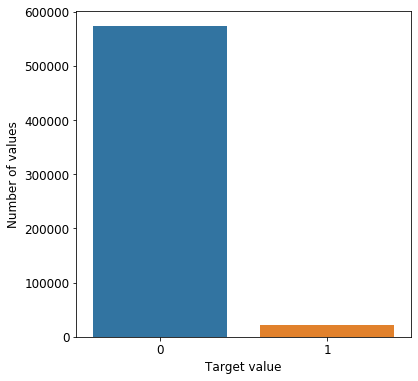

In [11]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))

x = trainset['target'].value_counts().index.values 
y = trainset['target'].value_counts().values
#Bar plot
#Order the bars descending on target mean
sns.barplot(ax =ax, x =x, y =y)
plt.ylabel('Number of values',fontsize = 12)
plt.xlabel('Target value',fontsize = 12)
plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
plt.show()

Only 3.64% of the target data have 1 value. This means that the training dataset is highly imbalanced.    
We can either 
* undersample the records with target = 0 
* oversample records with target = 1     
because is a large dataset, **we will do undersampling of records with target = 0.**

## Real featues

In [12]:
v = metadata[(metadata.type == 'real')&(metadata.preserve)].index 
trainset[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [13]:
#제곱근 함수 : trainset['ps~']*10을 제곱한 결과 
(pow(trainset['ps_car_12']*10,2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [14]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

**Features with missing values**
**ps_reg_o3, ps_car_12, ps_car_14** have missing values (their minimum value is -1)

**Registration features**
**ps_reg_01 and ps_reg_02** 는 분모로 10을 가진 분수이다.ex(0.1,0.2,0.3)

**Car Features**
**ps_car_12**는  (with some approximations) square roots (divided by 10) of natural numbers whilst ps_car_15 are square roots of natural numbers.

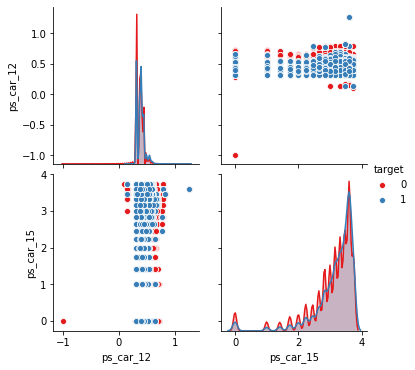

In [15]:
sample= trainset.sample(frac = 0.5)
# print(sample)
var = ['ps_car_12','ps_car_15','target']
sample = sample[var]
# print(sample)
sns.pairplot(sample,hue = 'target',palette = 'Set1',diag_kind='kde')
plt.show()

**Calculated features**
the features **ps_calc_01, ps_calc_02, ps_calc_03**은 비슷한 분포를 가지며 3칼럼 모두 최대값이 0.9이기 때문에   
The other calculated values have maximum value an integer value (5,6,7, 10,12).

C:\Study\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Study\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

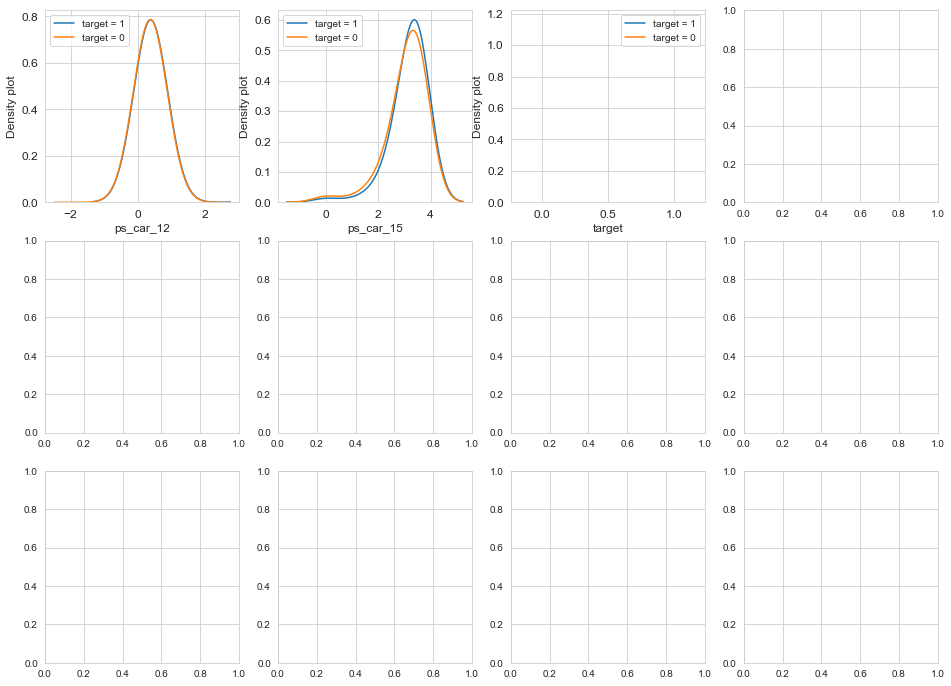

In [16]:
# Let's visualize the real features distribution using density plot.
v = metadata[(metadata.type == 'real')&(metadata.preserve)].index
i = 0 
t1 = trainset.loc[trainset['target']!=0] # 컴플레인 걸 사람 근데 왜 1로 안함
t0 = trainset.loc[trainset['target']==0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize = (16,12))

for f in var :
    i += 1 
    plt.subplot(3,4,i)
    sns.kdeplot(t1[f],bw = 0.5,label = 'target = 1')
    sns.kdeplot(t0[f],bw = 0.5, label = 'target = 0')
    plt.xlabel(f,fontsize=12)
    plt.ylabel('Density plot',fontsize = 12)
    locs, labels = plt.xticks()
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)

plt.show()

**ps_reg_02, ps_car_13, ps_car_15** 가 `target=0` 와 `target=1` 의 가장 다른 분포를 보여준다.

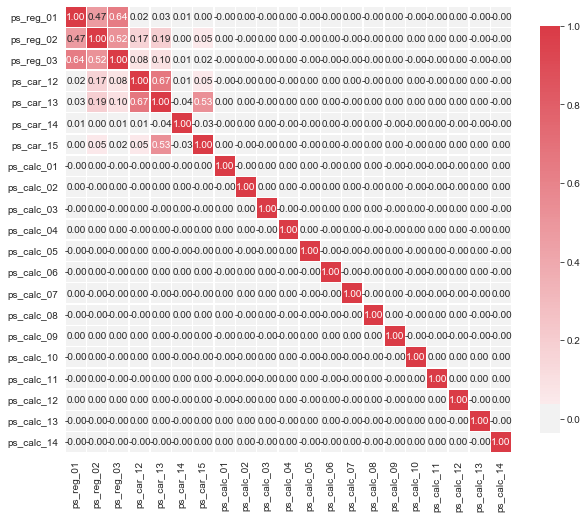

In [17]:
# Let's visualize the correlation between the real features 
def corr_heatmap(var) :
    correlations = trainset[var].corr()
    
    #Creating color map ranging between two colors 
    cmap = sns.diverging_palette(50,10,as_cmap=True)
    
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(correlations, cmap = cmap, vmax =1.0, center=0,fmt='.2f',
               square=True, linewidths=.5, annot = True, cbar_kws={'shrink':.75})
    plt.show()
    

var = metadata[(metadata.type =='real')&(metadata.preserve)].index 
corr_heatmap(var)

강한 상관관계를 가지고 있습니다.
* ps_reg_01 with ps_reg_02 (0.47);
* ps_reg_01 with ps_reg_03 (0.64);
* ps_reg_02 with ps_reg_03 (0.52);
* ps_car_12 with ps_car_13 (0.67);
* ps_car_13 with ps_car_15 (0.53);

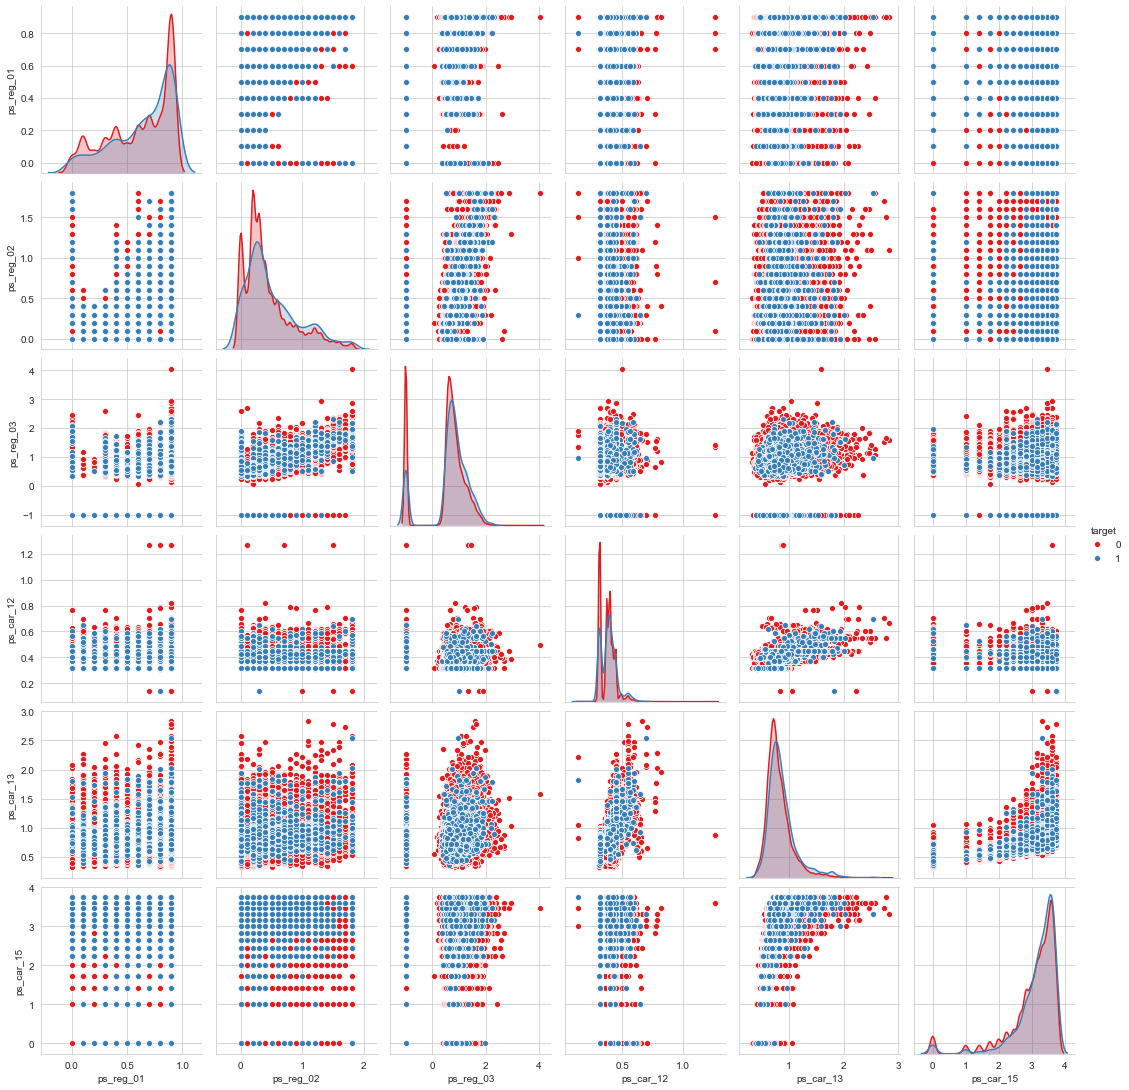

In [18]:
# Before representing the pairs, we subsample the data, 
# using only 2% in the sample.
sample = trainset.sample(frac = 0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,hue='target',palette='Set1',diag_kind='kde')
plt.show()

## Binary features 

In [19]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index 
trainset[v].describe()

,target,ps_ind_01,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's plot the distribution of the binary data in the training dataset. With `blue` we represent the percent of 0 and with `red` the percent of 1.

C:\Study\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000002DA99D631C8> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 432x288 with 0 Axes>

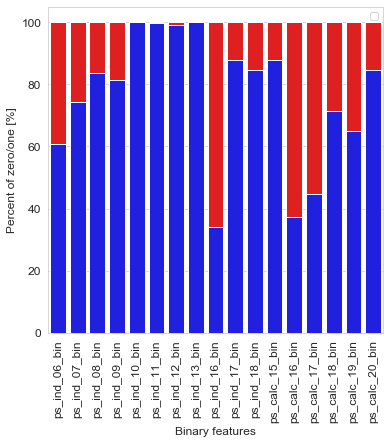

In [20]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = [] 
one_list = []
for col in bin_col :
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize = (6,6))
#Bar plot
p1 = sns.barplot(ax = ax, x = bin_col, y = zero_list, color = 'blue')
p2 = sns.barplot(ax= ax, x= bin_col, y = one_list, bottom = zero_list,color = 'red')

plt.ylabel('Percent of zero/one [%]',fontsize = 12)
plt.xlabel('Binary features',fontsize  =12)
locs,labels = plt.xticks()
plt.setp(labels, rotation = 90)
plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
plt.legend((p1,p2),('Zero','One'))
plt.show()

**ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin and ps_ind_13_bin** have very small number of values` 1` (lesss than 0.5%) whilst the number of value 1 is very large for **ps_ind_16_bin and ps_cals_16_bin **(more than 60%).

<Figure size 432x288 with 0 Axes>

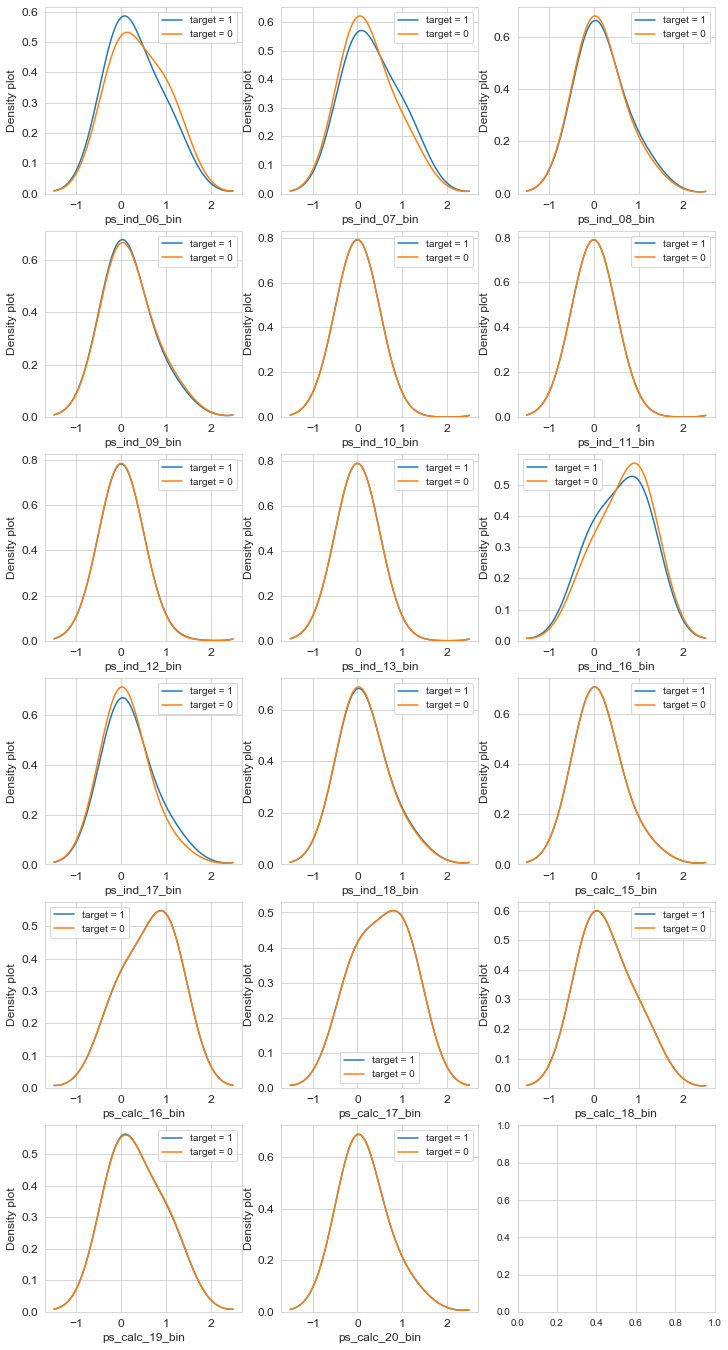

In [21]:
#  Let's see now the distribution of binary data 
#  and the corresponding values of target variable.
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin** shows high inbalance between distribution of values of `1` and `0` for values of target equals with 1 and 0, **ps_ind_08_bin** shows a small inbalance while the other features are well balanced, having similar density plots.

## Categorical features 

We will represent the distribution on `categorical data` in two ways.     
* First, we calculate the percentage of target=1 per category value 
* represent these percentages using bar plots.

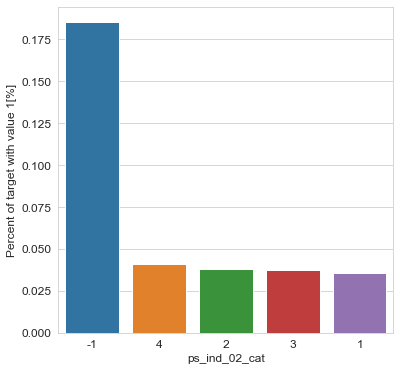

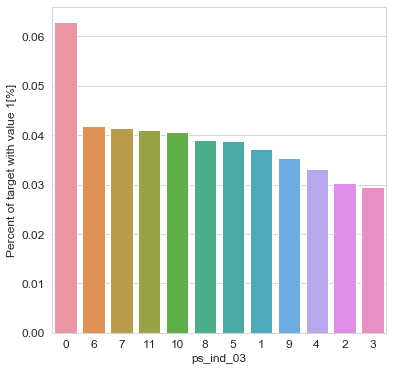

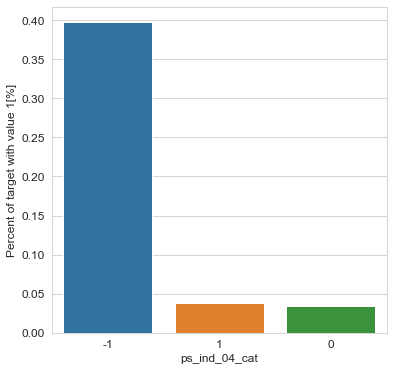

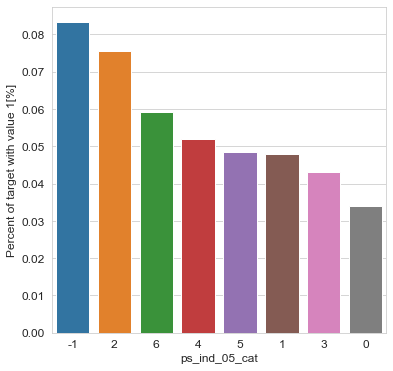

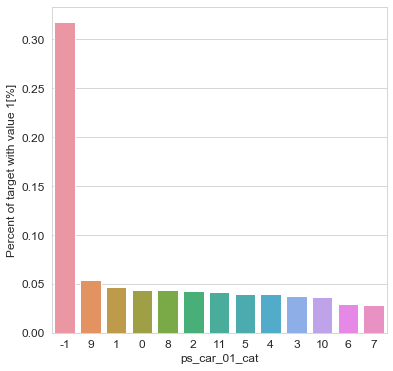

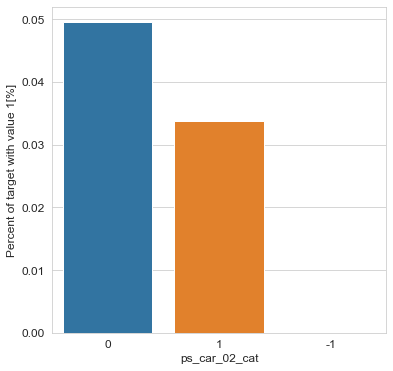

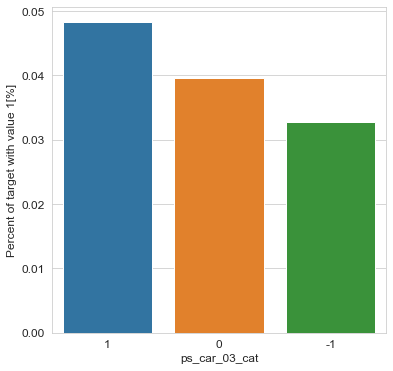

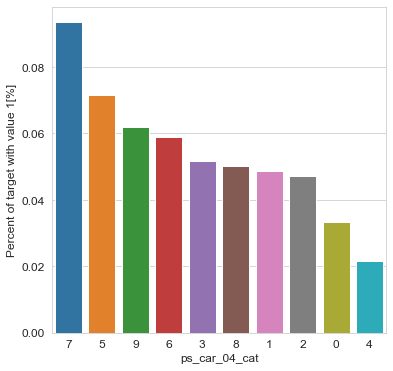

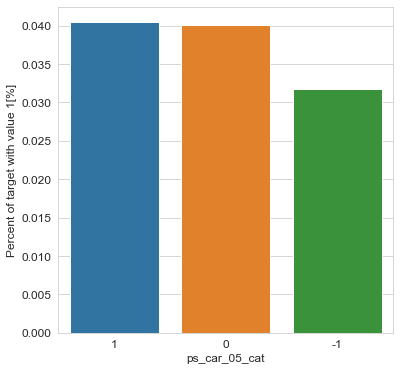

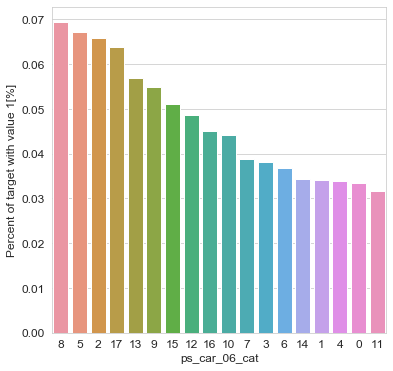

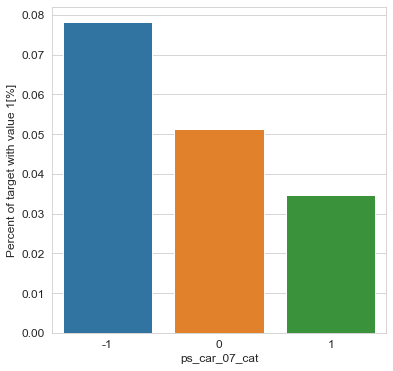

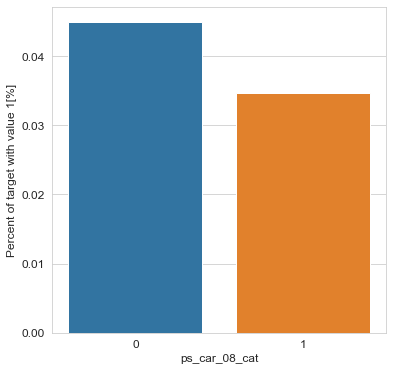

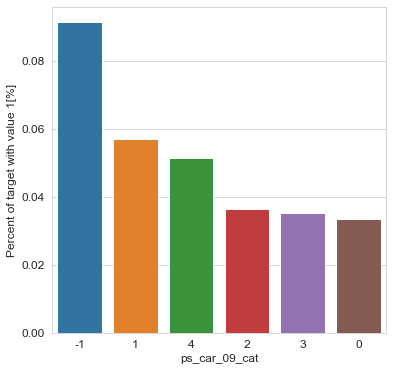

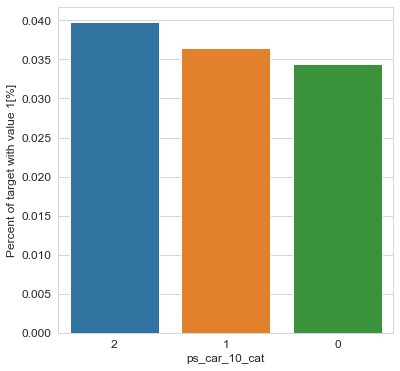

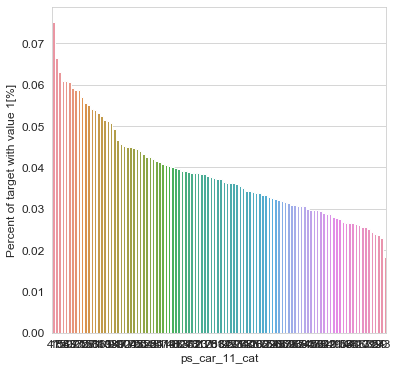

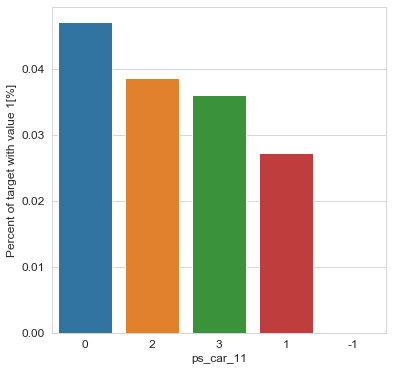

In [22]:
v = metadata[(metadata.type == 'categorical')&(metadata.preserve)].index 

for f in v :
    fig, ax = plt.subplots(figsize = (6,6))
    #Calculate the percentage of target 1 per category value
    cat_perc = trainset[[f,'target']].groupby([f],as_index = False).mean()
    cat_perc.sort_values(by = 'target',ascending = False, inplace = True)
    #Bar plot
    #Order the bars decending on target mean 
    sns.barplot(ax =ax, x = f,y='target',data=cat_perc,order = cat_perc[f])
    plt.ylabel('Percent of target with value 1[%]',fontsize = 12)
    plt.xlabel(f,fontsize = 12)
    plt.tick_params(axis = 'both',which = 'major',labelsize = 12)
    plt.show()

Alternativelly we represent the categorical features using density plot. We select values with `target=0` and `target=1` and represent both density plots on the same graphic.

<Figure size 432x288 with 0 Axes>

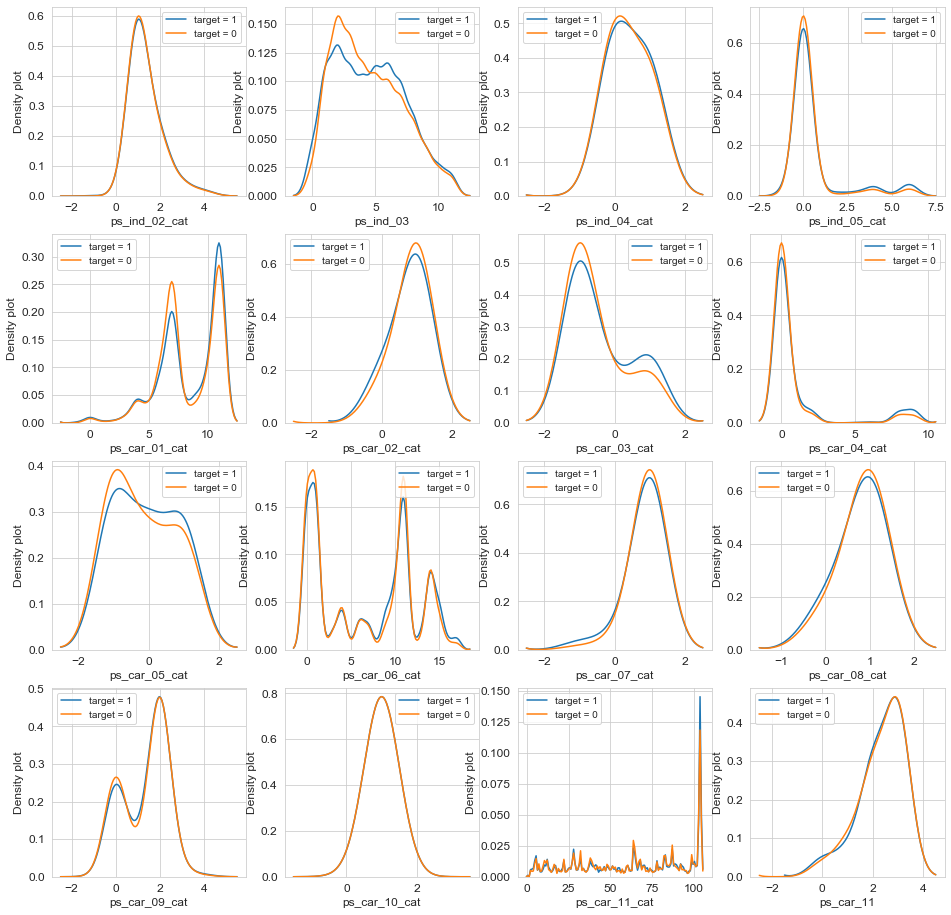

In [23]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_car_03_cat, ps_car_05_cat** shows the most different density plot between values associated with `target=0` and `target=1`.

## Data unbalance between train and test data 

Let's compare the distribution of the features in the train and test datasets.

We start with the `reg` or `registration` features.

<Figure size 432x288 with 0 Axes>

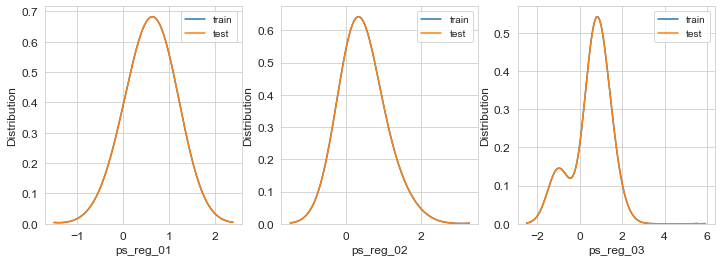

In [24]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `reg` features shows well balanced train and test sets.

<Figure size 432x288 with 0 Axes>

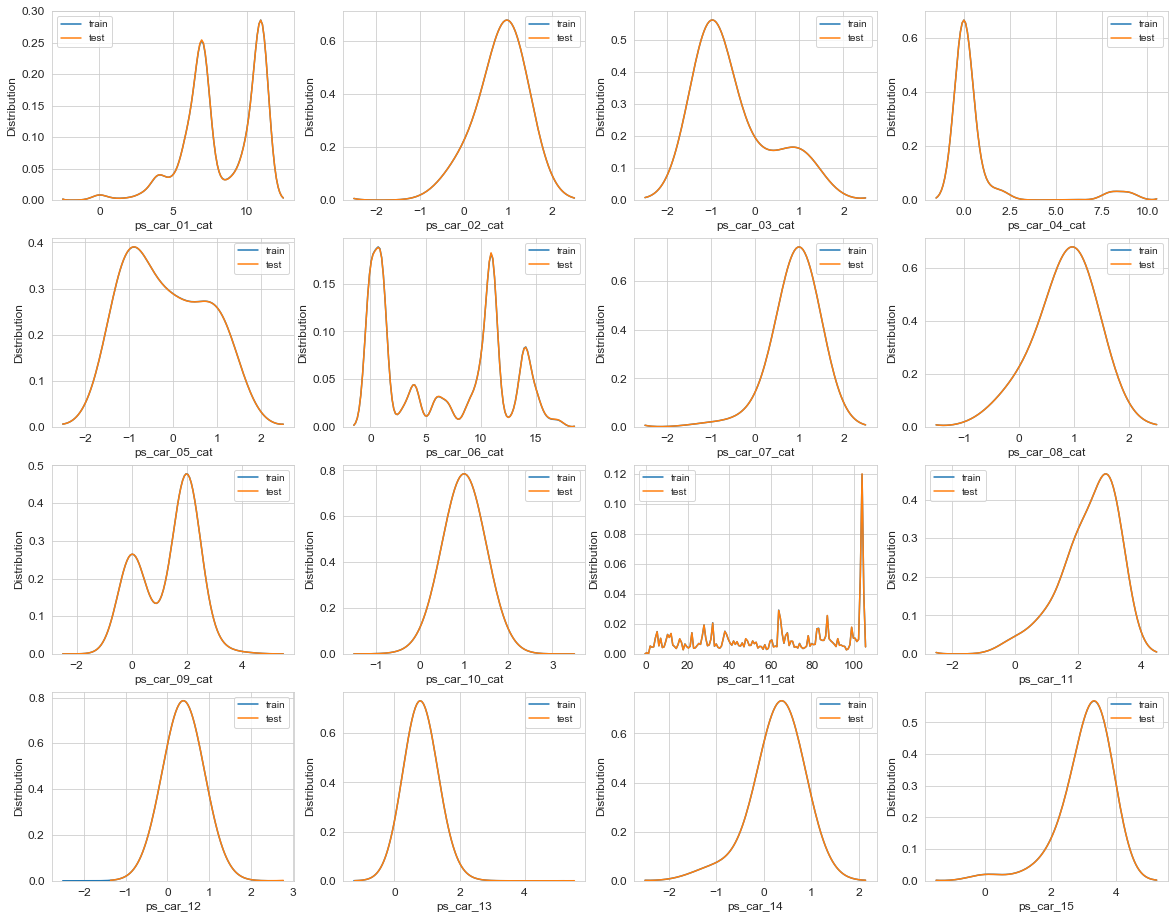

In [25]:
# Let's continue with car features

v = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for f in v:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[f], bw=0.5, label="train")
    sns.kdeplot(testset[f], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(f, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

From the `car` features, all variables looks well balanced between train and test set.

<Figure size 432x288 with 0 Axes>

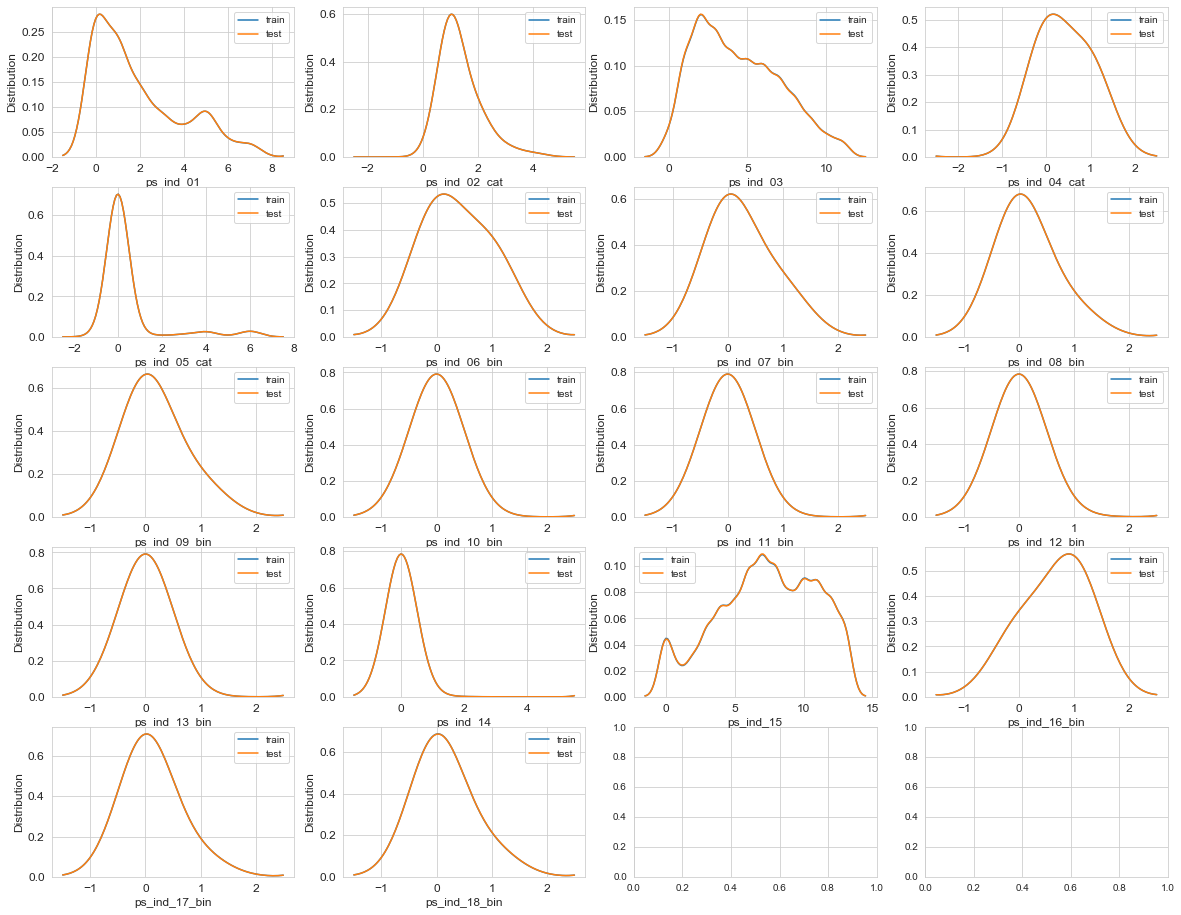

In [26]:
# Let's see ind(individual) values 
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All ind features are well balanced between `train` and `test` sets.

<Figure size 432x288 with 0 Axes>

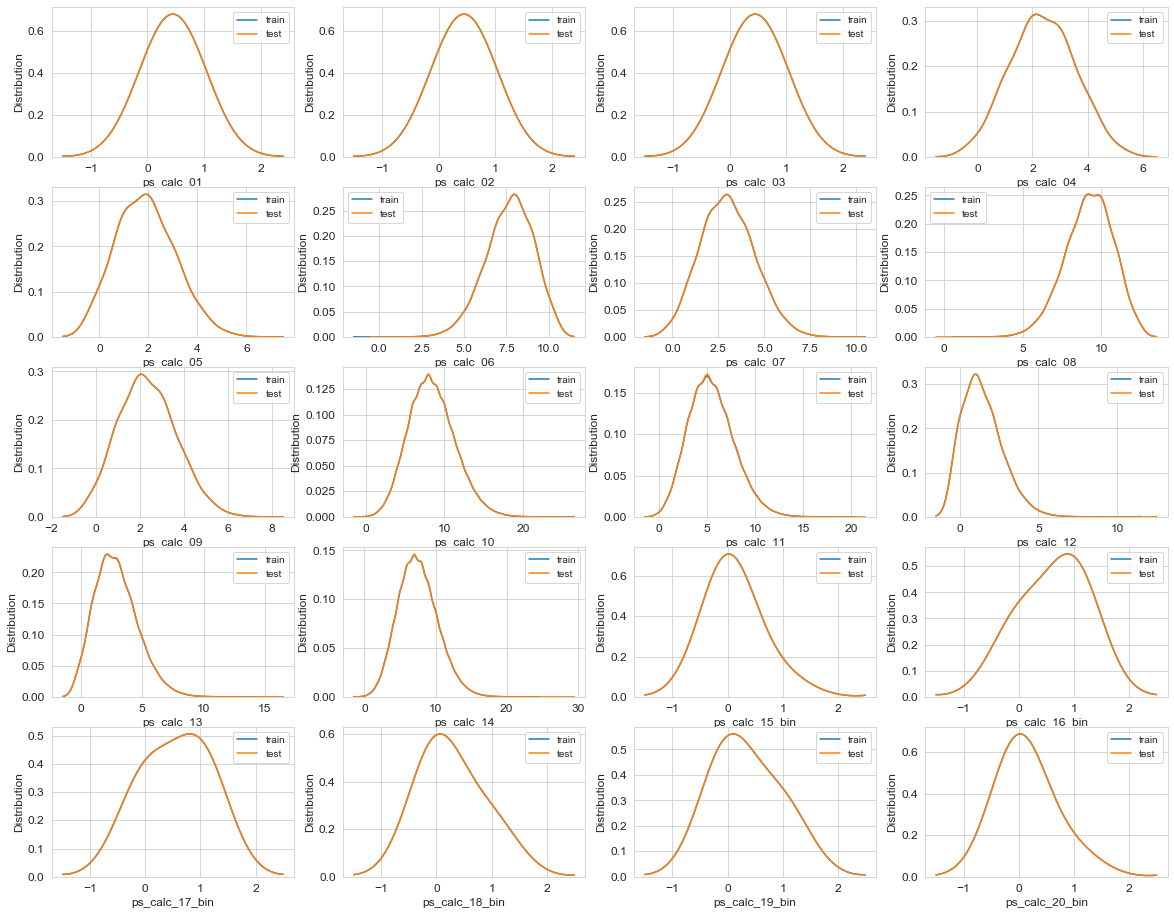

In [27]:
# Let's check now calc features 
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All calc features are well balanced between `train` and `test` sets

## Ceck data quality

In [28]:
vars_with_missing = [] 

for f in trainset.columns :
    missings = trainset[trainset[f]==-1][f].count()
    if missings > 0 :
        vars_with_missing.append(f)
        missings_perc = missings / trainset.shape[0]
        print('Variable {} has {} ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_calc_20_bin has 216 (0.04%) with missing values
Variable ps_calc_20_bin has 83 (0.01%) with missing values
Variable ps_calc_20_bin has 5809 (0.98%) with missing values
Variable ps_calc_20_bin has 107772 (18.11%) with missing values
Variable ps_calc_20_bin has 107 (0.02%) with missing values
Variable ps_calc_20_bin has 5 (0.00%) with missing values
Variable ps_calc_20_bin has 411231 (69.09%) with missing values
Variable ps_calc_20_bin has 266551 (44.78%) with missing values
Variable ps_calc_20_bin has 11489 (1.93%) with missing values
Variable ps_calc_20_bin has 569 (0.10%) with missing values
Variable ps_calc_20_bin has 5 (0.00%) with missing values
Variable ps_calc_20_bin has 1 (0.00%) with missing values
Variable ps_calc_20_bin has 42620 (7.16%) with missing values
In total, there are 13 variables with missing values


## Prepare the data for model 

Drop **calc** columns  
We also drop columns, as recommended in [5].

In [29]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis = 1)
testset = testset.drop(col_to_drop,axis =1 )

In [30]:
trainset.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15'],
      dtype='object')

### Drop variables with too many missing values
We select from the variables with missing values two,    `ps_car_03_cat` and `ps_car_05_cat` to drop. 

In [31]:
# Dropping the variables with too many missing values 
vars_to_drop = ['ps_car_03_cat','ps_car_05_cat']
trainset.drop(vars_to_drop, inplace= True, axis = 1)
testset.drop(vars_to_drop,inplace= True, axis = 1)
metadata.loc[(vars_to_drop),'keep'] = False 

In [32]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

### Replace ps_car_11_cat with encoded value
Using the target_encode function, we replace the `ps_car_11_cat` with an encoded value in both train and test datasets.

In [33]:
train_encoded, test_encoded = target_encode(trainset['ps_car_11_cat'],
                                           testset['ps_car_11_cat'],
                                           target = trainset.target,
                                           min_samples_leaf= 100,
                                           smoothing= 10,
                                           noise_level=0.01)
trainset['ps_car_11_cat_te'] = train_encoded 
trainset.drop('ps_car_11_cat', axis  = 1, inplace = True)
metadata.loc['ps_car_11_cat','keep'] = False 

testset['ps_car_11_cat_te']= test_encoded
testset.drop('ps_car_11_cat', axis = 1, inplace= True)

### Balance target variable
The target variable is highly unbalanced. This can be improved by either undersampling values with target = 0 or oversampling values with target = 1. Because there is a rather large training set, **we opt for the undersampling.**

In [34]:
desired_apriori = 0.10 

#Get the indices per target value 
idx_0 = trainset[trainset.target == 0].index 
idx_1 = trainset[trainset.target == 1].index

#Get original number of records per target value 
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target = 0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0  after undersampling: {}'.format(undersampled_nb_0))

# Randomy select records with target = 0 to get at the desired a priori 
undersampled_idx = shuffle(idx_0, random_state = 314, n_samples = undersampled_nb_0)

# Construct list with remaining indices 
idx_list = list(undersampled_idx) +list(idx_1)

#Return undersample data frame 
trainset = trainset.loc[idx_list].reset_index(drop = True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0  after undersampling: 195246


### Replace -1 values with NaN 
Most of the classifiers we would use have preety good strategies to manage missing (or NaN) values.

In [35]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### Dummify cat values 
We will create dummy variables for the categorical (cat) features

In [36]:
v = metadata[(metadata.type == 'categorical')&(metadata.preserve)].index
v 

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

In [37]:
car_features = [a for a in trainset.columns if a.endswith('cat')]

for column in car_features :
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis = 1)
    trainset = trainset.drop([column],axis =1)
    
for column in car_features :
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis = 1)
    testset = testset.drop([column],axis =1)   

### Drop unused and target columns 
We separate the id and target (drop these columns)

In [38]:
id_test = testset['id'].values 
target_train = trainset['target'].values 

trainset = trainset.drop(['target','id'],axis = 1)
testset = testset.drop(['id'],axis = 1)

In [39]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)


Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


# Prepare the model 

**Ensable class for cross validation and ensamble**
Prepare an Ensamble class to split the data in KFolds, train the models and ensamble the results.

The class has an init method (called when an Ensamble object is created) that accepts 4 parameters:


In [41]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

## Parameters for the base models
For the base models, we prepare three different LightGBM models and one XGB model.

Each model is used to train the data (using as well cross-validation, with 3 folds).

In [42]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 490

## Initialize the models with the parameters 
We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above.

In [43]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

#Stacking model 
log_model = LogisticRegression()

### Initialize the ensambling object
Using Ensamble.init we init the stacking object

In [44]:
stack = Ensemble(n_splits=  3, stacker = log_model,
                base_models=(lgb_model1,lgb_model2,lgb_model3,xgb_model))

# Run the predictive model
Calling the fit_predict method of stack object, we run the training of the base models, predict the target with each model, ensamble the results using the stacker model and output the stacked result.

In [ ]:
y_prediction = stack.fit_predict(trainset, target_train,testset)

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63703 [gini]: 0.27406
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63959 [gini]: 0.27919
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63482 [gini]: 0.26965
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63942 [gini]: 0.27884
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63992 [gini]: 0.27984
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63736 [gini]: 0.27472
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63693 [gini]: 0.27385
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63669 [gini]: 0.27337
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.63419 [gini]: 0.26839
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63875 [gini]: 0.27749
Base model 4: fit XGBClassifier model | fold 2
cros

# Prepare the submission

In [ ]:
submission = pd.DataFrame()
submission['id'] = id_test 
submission['target'] = y_prediction 
submission.to_csv('stacked.csv',index = False)